In [3]:
import pandas as pd
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
# from keras.layers.merge import Concatenate
import matplotlib.gridspec as gridspec
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense,Dropout, Bidirectional
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, BayesianRidge

In [4]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
cd /content/drive/MyDrive/ColabNotebooks/ML/natural-gas

/content/drive/MyDrive/ColabNotebooks/ML/natural-gas


In [7]:
data = pd.read_csv("processed_nasdaq.csv",index_col="Date", parse_dates=True)
cols = ["close", "open", "high", "low"]
new_data = data[cols].astype(float)
new_data

chloe=new_data[['close','open','high','low']].astype(float)
god=new_data['close'].astype(float)

In [8]:
new_data.isnull().sum()

close    0
open     0
high     0
low      0
dtype: int64

In [9]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2551 entries, 2022-04-29 to 2012-05-02
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   2551 non-null   float64
 1   open    2551 non-null   float64
 2   high    2551 non-null   float64
 3   low     2551 non-null   float64
dtypes: float64(4)
memory usage: 99.6 KB


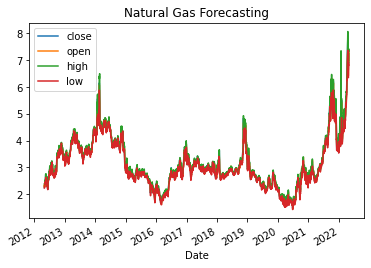

In [10]:
new_data.plot()
plt.title("Natural Gas Forecasting")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


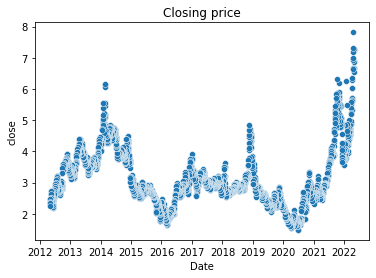

In [11]:
sns.scatterplot('Date','close',data=new_data)
plt.title('Closing price')
plt.show()

In [12]:
def create_dataset(dataset, look_back=3):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [13]:
look_back=5
dataset=god

scaler = MinMaxScaler(feature_range=(0, 1))

dataset = scaler.fit_transform(np.array(dataset).reshape(-1,1))

train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]
#print(len(train), len(test))

#print(train)

trainX, y_train = create_dataset(train, look_back)
testX, y_test = create_dataset(test, look_back)

X_train = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
X_test = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [14]:
n_future = 1
features=2
timeSteps=5

model = Sequential()
model.add(Bidirectional(LSTM(units=50, return_sequences=True, 
                             input_shape=(X_train.shape[1], 1))))

model.add(LSTM(units= 50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units= 50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units= 50))
model.add(Dropout(0.2))
model.add(Dense(units = n_future))

model.compile(optimizer="adam", loss="mean_squared_error", metrics=["acc"])



In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 1, 100)           22400     
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 1, 50)             30200     
                                                                 
 dropout (Dropout)           (None, 1, 50)             0         
                                                                 
 lstm_2 (LSTM)               (None, 1, 50)             20200     
                                                                 
 dropout_1 (Dropout)         (None, 1, 50)             0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                        

In [18]:
model.fit(X_train, y_train,epochs=50 , verbose=1)

Epoch 1/50
64/64 [==============================] - 10s 9ms/step - loss: 0.0294 - acc: 9.8328e-04
Epoch 2/50
64/64 [==============================] - 1s 9ms/step - loss: 0.0031 - acc: 9.8328e-04
Epoch 3/50
64/64 [==============================] - 1s 9ms/step - loss: 0.0020 - acc: 9.8328e-04
Epoch 4/50
64/64 [==============================] - 1s 9ms/step - loss: 0.0018 - acc: 9.8328e-04
Epoch 5/50
64/64 [==============================] - 1s 9ms/step - loss: 0.0016 - acc: 9.8328e-04
Epoch 6/50
64/64 [==============================] - 1s 9ms/step - loss: 0.0015 - acc: 9.8328e-04
Epoch 7/50
64/64 [==============================] - 1s 9ms/step - loss: 0.0013 - acc: 9.8328e-04
Epoch 8/50
64/64 [==============================] - 1s 9ms/step - loss: 0.0013 - acc: 9.8328e-04
Epoch 9/50
64/64 [==============================] - 1s 9ms/step - loss: 0.0012 - acc: 9.8328e-04
Epoch 10/50
64/64 [==============================] - 1s 9ms/step - loss: 0.0012 - acc: 9.8328e-04
Epoch 11/50
64/64 [=========

16/16 [==============================] - 0s 5ms/step


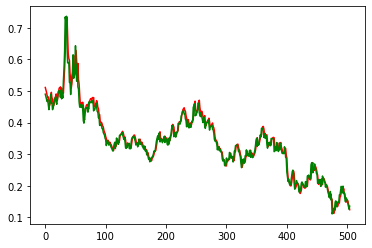

In [40]:
prediction = model.predict(X_test)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(prediction)+look_back, :] = prediction
# shift test predictions for plotting
#plt.plot(scaler.inverse_transform(dataset))
#plt.plot(trainPredictPlot, color='red')
plt.plot(prediction,color='red')
plt.plot(y_test, color="green")
#plt.legend(['Actual','Train','Test'])
plt.show()

In [27]:
X_test.shape

(505, 1, 5)

In [30]:
y_test.shape

(505, 1)

In [34]:
trainPredictPlot[len(dataset)-505:].shape
# y_test.shape

(505, 1)

In [20]:
X=chloe
y=god
bayesian = BayesianRidge(fit_intercept=False, normalize=True)
bayesian.fit(X, y)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), BayesianRidge())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  FutureWarning,


BayesianRidge(fit_intercept=False, normalize=True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


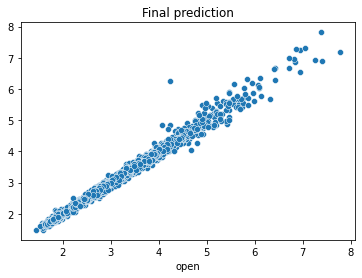

In [21]:
bayesian_pred = bayesian.predict(X)
sns.scatterplot(X['open'],bayesian_pred)
plt.title('Final prediction')
plt.show()

In [41]:
from sklearn.metrics import *
from math import sqrt

MSE = mean_squared_error(prediction, y_test)
R2 = r2_score(prediction, y_test)
RMSE = sqrt(mean_squared_error(prediction, y_test))
MAE = mean_absolute_error(prediction, y_test)
MAPE = mean_absolute_percentage_error(prediction, y_test)


from tabulate import tabulate
results= [["LSTM With NASDAQ DATASET",MSE,R2,RMSE,MAE,MAPE]]
col_names = ["Model/Metrics", "MSE","R-Squared","RMSE","MAE","MAPE"]
print(tabulate(results,headers=col_names,tablefmt="fancy_grid"))

╒══════════════════════════╤════════════╤═════════════╤═══════════╤═══════════╤═══════════╕
│ Model/Metrics            │        MSE │   R-Squared │      RMSE │       MAE │      MAPE │
╞══════════════════════════╪════════════╪═════════════╪═══════════╪═══════════╪═══════════╡
│ LSTM With NASDAQ DATASET │ 0.00035575 │    0.969229 │ 0.0188613 │ 0.0130973 │ 0.0391393 │
╘══════════════════════════╧════════════╧═════════════╧═══════════╧═══════════╧═══════════╛
